# Deceptive Speech Classification with RNN

This project is inspired by the joint research conducted by Columbia University, SRI International and University of Colorado Boulder to distinguish deceptive and non-deceptive speech. The data consists of 32 hours of audio interviews from 32 native speakers of Standard American English (16 male, 16 female) recruited from the Columbia University student population and the community. The idea of our project is to explore or extend deep learning techniques with the audio data, specifically recurrent neural network (RNN).

Essentially, this forms a sequence binary classification problem. The data has been annotated as follows:
* Positive-class (T): Truthful  (label: 1)
* Negative-class (F): Deceitful (label: 0)

Note: the original CSC Deceptive Speech Corpus contains both audio and textual (i.e., transcripts) data, in my dataset the features have been extracted and pre-computed to Mel-frequency cepstral coefficients (MFCC) matrices from the raw audio inputs. Each MFCC vector represents a frame size of 25 ms with 13 MFC coefficients. The total frames correpsonds to the overall sequence length.

Additionally, some of the original transcripts have been missing in my dataset, so I will be only using the MFCC features for this experiment.

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

print(tf.__version__)

1.2.1


### Utility Functions

In [2]:
def read_data(data_dir, suffix='_'):
    """
    """
    data = np.load(data_dir)
    
    return data['X' + suffix], data['y' + suffix], data['l' + suffix]

In [3]:
def make_batches(*arrays, batch_size=1, shuffle=True):
    """
    """
    arrays = list(arrays)
    num_samples = arrays[0].shape[0]

    if shuffle:
        s = np.arange(num_samples)
        np.random.shuffle(s)
        arrays = [arr[s] for arr in arrays]
    
    return [np.array_split(arr, num_samples // batch_size) for arr in arrays]

In [4]:
def resample(inputs, seq_lens, sample_len):
    """
    Splice input sequences into sub-sequences with a given sample length
    """
    threshold_index = seq_lens > sample_len
    resampled = []
    for i, x in enumerate(inputs):
        if threshold_index[i]:
            resampled += np.array_split(x, seq_lens[i] // sample_len)
        else:
            resampled.append(x)
    return resampled

In [5]:
def pad_sequences(inputs, seq_lens):
    """
    This function performs zero-padding on the given sequences to their maximum lengths
    
    Args:
        mfcc_feats: a list of original MFCC arrays
        mfcc_lens: a list of original MFCC frame sizes (i.e., length)

    Returns:
        mfcc_feats: a list of padded MFCC arrays
    """
    max_len = max(seq_lens)
    for i, x in enumerate(inputs):
        inputs[i] = np.pad(x, ((0, max_len - seq_lens[i]), (0, 0)), 'constant')

    return inputs

In [6]:
a, b = make_batches(np.array([[1],[2],[3],[4],[5],[6]]),
                    np.array([1,2,3,4,5,6]),
                    batch_size=2,
                    shuffle=False)
print(a)
print(b)

[array([[1],
       [2]]), array([[3],
       [4]]), array([[5],
       [6]])]
[array([1, 2]), array([3, 4]), array([5, 6])]


In [7]:
# X_all = np.vstack([X_train, X_test])
# y_all = np.hstack([y_train, y_test])
# l_all = np.hstack([l_train, l_test])

# print(X_all.shape, y_all.shape, l_all.shape)

## Preprocessing

Since each MFCC input (X_raw) has different length from its raw audio source, we also store the timesteps in l_raw besides its label y_raw. In total, we have 315 samples with variable lengths.

In [7]:
data_dir = '/resources/data/polygraph/data/'
csc_data_1 = data_dir + 'csc_data_1.npz'
csc_data_2 = data_dir + 'csc_data_2.npz'
X_1, y_1, l_1 = read_data(csc_data_1)
X_2, y_2, l_2 = read_data(csc_data_2)

X_raw = np.hstack([X_1, X_2])
y_raw = np.hstack([y_1, y_2])
l_raw = np.hstack([l_1, l_2])

print(len(X_raw), len(y_raw), len(l_raw))

# assert X_raw[0].shape[0] == l_raw[0]
# assert X_raw[-1].shape[0] == l_raw[-1]

315 315 315


### Split  Positive/Negative-class
We have 106 samples labeled as truthful (T), and 209 as deceitful (F) in the raw data.

In [8]:
pos_idx = y_raw > 0
neg_idx = np.logical_not(pos_idx)

l_pos = l_raw[pos_idx]
l_neg = l_raw[neg_idx]

X_pos = X_raw[pos_idx]
X_neg = X_raw[neg_idx]

y_pos = y_raw[pos_idx]
y_neg = y_raw[neg_idx]

print("Pos samples:", len(l_pos))
print("Neg samples:", len(l_neg))

Pos samples: 106
Neg samples: 209


The class ratio (F/T) is about 2:1 in the raw data

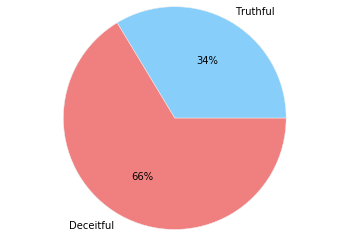

In [9]:
plt.figure()
colors = ['lightskyblue', 'lightcoral']
plt.pie([len(l_pos), len(l_neg)], labels=('Truthful', 'Deceitful'), autopct='%.0f%%', colors=colors)
plt.axis('equal')
plt.show()

As seen below, each element in l_pos/l_neg corresponds to the length/timesteps of the element in the inputs X_pos/X_neg.

In [10]:
print(X_pos[0].shape, l_pos[0])
print(X_neg[0].shape, l_neg[0])

(13177, 13) 13177
(12396, 13) 12396


In [11]:
X_pos[0]

array([[ -9.77395166, -24.07673986,  -9.24941439, ...,  15.16875826,
        -12.20706255,  -4.11609648],
       [ -9.86051053, -26.43133201,  -2.91172927, ...,  12.31655751,
        -19.16558898,  -5.10947936],
       [ -9.8325141 , -26.51552373,   0.89143323, ...,  10.13146444,
        -18.01582931,  -1.10708005],
       ..., 
       [-10.08965913, -18.24696103,   6.7898253 , ...,   6.0780546 ,
         11.60368098,  -6.33365535],
       [ -9.62998383, -20.38640225,   9.15948667, ...,  -1.3187338 ,
          7.07003494, -10.83896448],
       [ -9.73118316, -20.11820257,   8.42276306, ...,  -0.38243727,
          2.55210597, -13.41624378]])

### Data Visualization

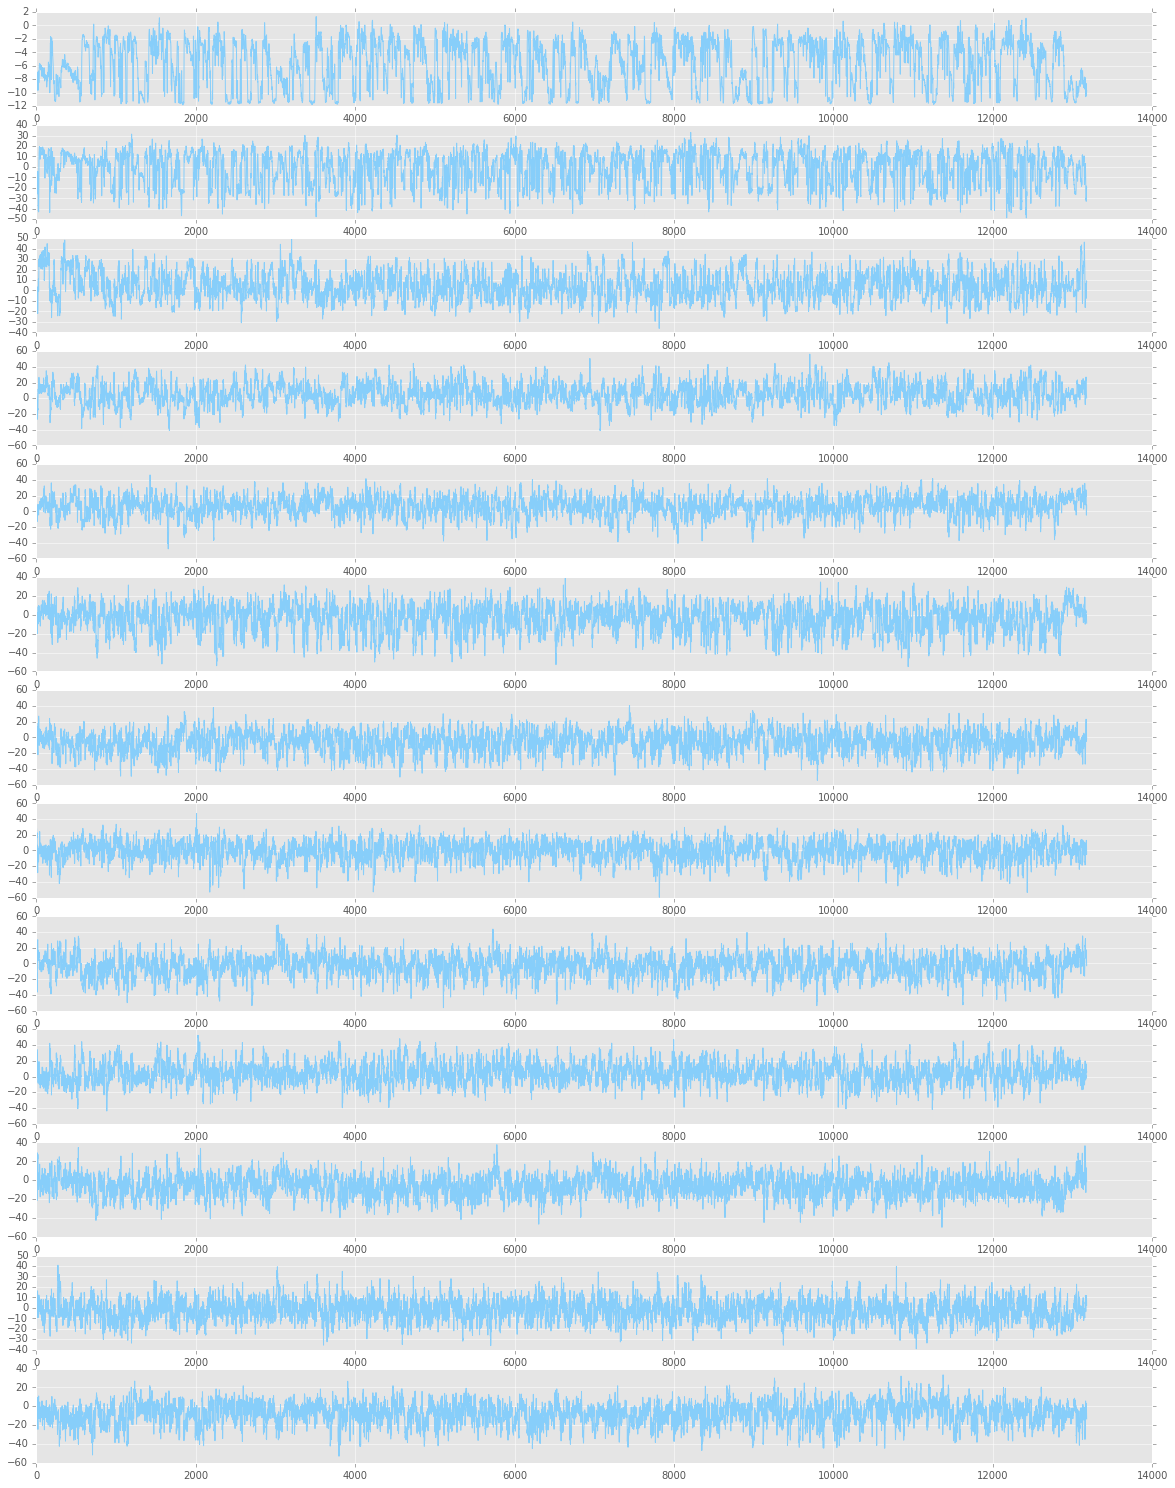

In [12]:
# d = 13, MFCC coefficients
d = X_pos[0].shape[1]
plt.figure(figsize=(20, 26))
for i in range(d):
    plt.subplot(d, 1, i+1)
    plt.plot(X_pos[0][:, i], color='lightskyblue')
plt.show()

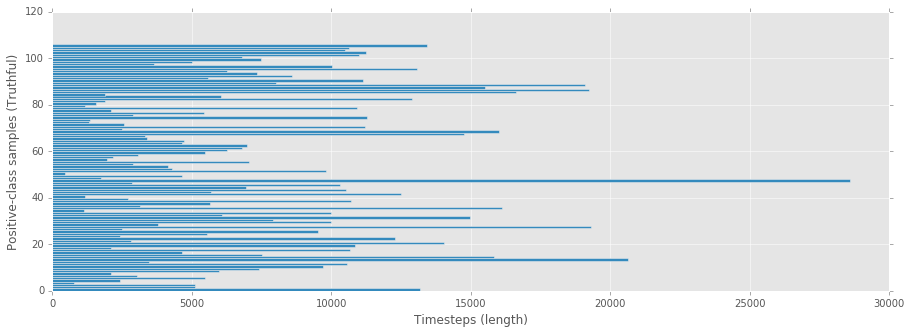

In [13]:
plt.figure(figsize=(15, 5))
plt.barh(range(len(l_pos)), l_pos, height=1)
plt.xlabel('Timesteps (length)')
plt.ylabel('Positive-class samples (Truthful)')
plt.show()

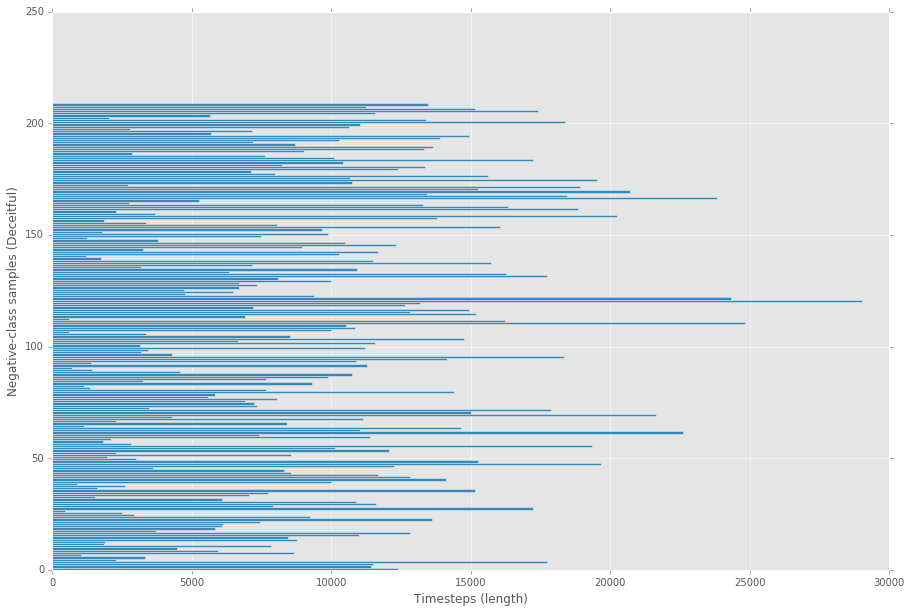

In [14]:
plt.figure(figsize=(15, 10))
plt.barh(range(len(l_neg)), l_neg, height=1)
plt.xlabel('Timesteps (length)')
plt.ylabel('Negative-class samples (Deceitful)')
plt.show()

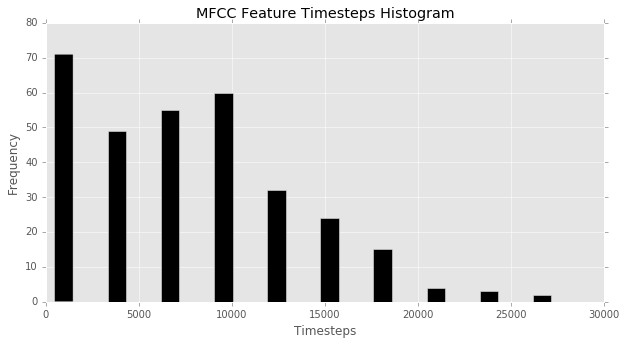

In [15]:
plt.figure(figsize=(10, 5))
plt.hist(l_raw, width=1000, color='k')
plt.title('MFCC Feature Timesteps Histogram')
plt.xlabel('Timesteps')
plt.ylabel('Frequency')
plt.show()

In [16]:
np.mean(l_raw)

8687.4349206349198

As seen above, the timesteps distribution is heavily righ-skewed. The average timesteps is around 8700 steps, which is quite high for RNN (250-500 steps is the norm). It is recommended to resample the raw data into sub-sequences, and this also helps to generate more samples for training.

In [ ]:
over_pos_idx = l_pos > 250
pos_counter = 0
for i, x in enumerate(X_pos):
    if over_pos_idx[i]:
        pos_counter += len(np.array_split(x, l_pos[i] // 250))
    else:
        pos_counter += 1

print(pos_counter)

In [ ]:
over_neg_idx = l_neg > 600
neg_counter = 0
for i, x in enumerate(X_neg):
    if over_neg_idx[i]:
        neg_counter += len(np.array_split(x, l_neg[i] // 600))
    else:
        neg_counter += 1

print(neg_counter)

In [ ]:
pos_counter / (pos_counter + neg_counter)

In [19]:
X_pos_resampled = resample(X_pos, l_pos, 250)
X_neg_resampled = resample(X_neg, l_neg, 250)

num_pos_resampled = len(X_pos_resampled)
num_neg_resampled = len(X_neg_resampled)

In [20]:
print("Pos samples:", num_pos_resampled)
print("Neg samples:", num_neg_resampled)

Pos samples: 3143
Neg samples: 7646


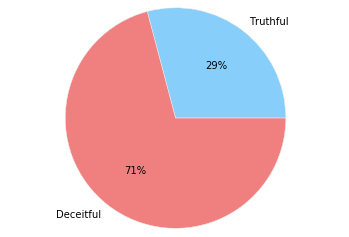

In [21]:
plt.figure()
colors = ['lightskyblue', 'lightcoral']
plt.pie([num_pos_resampled, num_neg_resampled], labels=('Truthful', 'Deceitful'), autopct='%.0f%%', colors=colors)
plt.axis('equal')
plt.show()

The class ratio in the resampled data becomes 3:7, which is still acceptable. Then, we merge the resampled data and generate new labels and lengths accordingly. Now, we have total 10789 samples, all sequence lengths are ranging from 250 to 500 steps.

In [22]:
X_resampled = X_pos_resampled + X_neg_resampled
# To categorical
y_resampled = np.array([0, 1] * num_pos_resampled +
                       [1, 0] * num_neg_resampled).reshape(-1, 2)
l_resampled = np.array([x.shape[0] for x in X_resampled])

print(len(X_resampled), len(y_resampled), len(l_resampled))

10789 10789 10789


### Pad Sequence
The last step in the preprocessing is to zero-pad the data to the maximum length of the inputs, since TF only allows fixed dimention input.

In [24]:
padded = pad_sequences(X_resampled, l_resampled)
X_resampled_padded = np.array(padded, dtype=np.float)

print(X_resampled_padded.shape)

(10789, 476, 13)


In [25]:
X_resampled_padded[0, :, :]

array([[ -9.77395166, -24.07673986,  -9.24941439, ...,  15.16875826,
        -12.20706255,  -4.11609648],
       [ -9.86051053, -26.43133201,  -2.91172927, ...,  12.31655751,
        -19.16558898,  -5.10947936],
       [ -9.8325141 , -26.51552373,   0.89143323, ...,  10.13146444,
        -18.01582931,  -1.10708005],
       ..., 
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ]])

In preliminary stage, we split the data to 90:10% ratio for training and validation.

In [26]:
X_train, X_test, y_train, y_test, l_train, l_test = train_test_split(X_resampled_padded,
                                                                     y_resampled,
                                                                     l_resampled,
                                                                     test_size=0.1,
                                                                     random_state=13)

In [27]:
train_size, test_size = len(l_train), len(l_test)
print("Train/test size:", train_size, test_size)

class_train = y_train.sum(axis=0)
class_test = y_test.sum(axis=0)
print("Class ratio (F/T) in train:", class_train)
print("Class ratio (F/T) in test:", class_test)

Train/test size: 9710 1079
Class ratio (F/T) in train: [6884 2826]
Class ratio (F/T) in test: [762 317]


In [48]:
class Polygraph(object):
    """
    Main model that constructs TF graph and perform training and validation
    
    Args:
        direction:  Choice of unidiretional or bidirection RNN
        num_units:  Number of hidden units on a RNN layer
        num_layers: Number of RNN layers
        lr:         Learning rate
    
    Return:
        Model object
    """
    def __init__(self, num_units, num_layers, rnn_type='lstm', direction='uni', lr=1e-3):
        self.inputs = None
        self.targets = None
        self.seq_lens = None
        self.keep_prob = None
        
        self._num_units = num_units
        self._num_layers = num_layers
        self._rnn_type = rnn_type
        self._direction = direction

        self.logits = None
        self.loss = None
        self.predictions = None
        self.lr = lr
        self.optimizer = None
        self.accuracy = None

        # self._build_graph()
    
    def _add_placeholders(self):
        """Add placeholders"""
        self.inputs = tf.placeholder(tf.float32, [None, None, Config.num_feats], name='inputs')
        self.targets = tf.placeholder(tf.float32, [None, Config.num_classes], name='targets')
        self.seq_lens = tf.placeholder(tf.int32, [None], name='seq_lens')
        self.keep_prob = tf.placeholder(tf.float32, name='keep_prob')
        self.pos_weight = tf.placeholder(tf.float32, name='pos_weight') # Positive-class weight

    def _add_feed_dict(self, X_batch, y_batch, l_batch, keep_prob, pos_weight):
        """Add feed_dict"""
        feed_dict = {self.inputs: X_batch,
                     self.targets: y_batch,
                     self.seq_lens: l_batch,
                     self.keep_prob: keep_prob,
                     self.pos_weight: pos_weight}
        return feed_dict

    def _add_prediction_op(self):
        """Construct network and predicition op"""
        
        # RNN cell definition helper
        def rnn_cell(num_units, keep_prob, rnn_type='lstm'):
            if rnn_type == 'lstm':
                cell = tf.nn.rnn_cell.LSTMCell(num_units)
            elif rnn_type == 'gru':
                cell = tf.nn.rnn_cell.GRUCell(num_units)
            elif rnn_type == 'rnn':
                cell = tf.nn.rnn_cell.RNNCell(num_units)
            else:
                raise Exception("Unknown specified rnn_type '{}'".format(rnn_type))
            
            return tf.nn.rnn_cell.DropoutWrapper(cell, output_keep_prob=keep_prob)
        
        # For sequence classification, we need the very last relevant output that supposes to
        # contain the entire information of the sequence from the history 
        last = None
        if self._direction == 'uni':
            # Unidirectional (stacked if layers > 1)
            cell = [rnn_cell(self._num_units, 1., rnn_type=self._rnn_type)
                    for _ in range(self._num_layers)]
            network = tf.nn.rnn_cell.MultiRNNCell(cell)

            # 'outputs' is of shape [batch_size, timesteps, num_units]
            outputs, _ = tf.nn.dynamic_rnn(network,
                                           self.inputs,
                                           sequence_length=self.seq_lens,
                                           dtype=tf.float32)
            
            # Extract the last relevant output from dynamic run using variable-length sequences
            last = self._extract_relevant(outputs, self.seq_lens - 1)
            
        elif self._direction == 'bi':
            # Bidirectional
            cell_fw = rnn_cell(self._num_units, self.keep_prob, rnn_type=self._rnn_type)
            cell_bw = rnn_cell(self._num_units, self.keep_prob, rnn_type=self._rnn_type)
            outputs, _ = tf.nn.bidirectional_dynamic_rnn(cell_fw,
                                                         cell_bw,
                                                         self.inputs,
                                                         sequence_length=self.seq_lens,
                                                         dtype=tf.float32)
            # Unpack forward/backward outputs
            output_fw, output_bw = outputs
            
            # Not sure why cannot use the staticmethod here!
            # last_fw = self._extract_relevant(output_fw, self.seq_lens - 1) 
            batch_range = tf.range(tf.shape(output_fw)[0])
            indices = tf.stack([batch_range, self.seq_lens - 1], axis=1)
            last_fw = tf.gather_nd(output_fw, indices)

            # The last output from the backward layer locates at the first timestep
            last_bw = output_bw[:, 0, :]
            last = tf.concat([last_fw, last_bw], 1)
            
        else:
            raise Exception("Unknown specified direction '{}'".format(self._direction))

        # Apply ReLu
        relu = tf.nn.relu(last, name='relu')
        
        # Apply dropout
        drop = tf.nn.dropout(relu, self.keep_prob)
        
        # For binary classification, we just need one unit from the fully-connected
        # Weights are initialized using truncated normal initializer
        # Biases are initialized with non-zero for layer pre-activation
        self.logits = tf.layers.dense(drop,
                                      units=Config.num_classes,
                                      kernel_initializer=tf.truncated_normal_initializer(stddev=0.01),
                                      bias_initializer=tf.constant_initializer(0.1),
                                      name='dense')
        # self.predictions = tf.cast(tf.greater(self.logits, 0.), tf.float32)
        self.predictions = tf.nn.softmax(self.logits)

    def _add_loss_op(self):
        """Add loss"""
        # For binary classification, we need sigmoid cross-entropy loss
#         ce = tf.nn.sigmoid_cross_entropy_with_logits(self.targets, self.logits)
        ce = tf.nn.weighted_cross_entropy_with_logits(targets=self.targets,
                                                      logits=self.logits,
                                                      pos_weight=self.pos_weight)
        # Use tf.nn.softmax_cross_entropy_with_logits_v2 for TF 1.4+
#         ce = tf.nn.softmax_cross_entropy_with_logits(labels=self.targets,
#                                                      logits=self.logits)
        self.loss = tf.reduce_mean(ce)
        
        # L2-regularization
#         with tf.variable_scope('dense', reuse=True):
#             weights = tf.get_variable('kernel')
#         l2_penalty = tf.nn.l2_loss(weights, name='l2-penalty')
#         self.loss = tf.reduce_mean(self.loss + Config.beta * l2_penalty)

    def _add_metric_op(self):
        """Add evaluation metric"""
        # correct = tf.equal(self.targets, self.predictions)
        correct = tf.equal(tf.argmax(self.targets, 1), tf.argmax(self.predictions, 1))
        self.accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name='accuracy')

    def _add_training_op(self):
        """Add training op"""
        train_op = tf.train.AdamOptimizer(self.lr)
        # self.optimizer = train_op.minimize(self.loss)
        
        # Gradient clipping
        gradients = train_op.compute_gradients(self.loss)
        capped_gradients = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gradients]
        self.optimizer = train_op.apply_gradients(capped_gradients)
        
    def _add_summary_op(self):
        """Merge summary"""
        self.merge_summary = tf.summary.merge_all()

    def build_graph(self):
        """Construct the computational graph"""
        self._add_placeholders()
        self._add_prediction_op()
        self._add_loss_op()
        self._add_metric_op()
        self._add_training_op()
        # self._add_summary_op()

    def run(self, session, X_batch, y_batch, l_batch, keep_prob, pos_weight=1, train=True):
        """
        Call to run
        
        Args
            session: Session object
            X_batch: A batch of inputs
            y_batch: A batch of targets
            l_batch: A batch of sequence lengths
            keep_prob: Dropout (keep) probabilities
            pos_weight: Positive-class weight
            train: Training flag
        
        Returns
            loss, accuracy, predictions
        """
        feed = self._add_feed_dict(X_batch, y_batch, l_batch, keep_prob, pos_weight)
        
        if train:
            _ = session.run([self.optimizer], feed)
        
        loss, accuracy, pred = session.run([self.loss, self.accuracy, self.predictions], feed)
        
        return loss, accuracy, pred
    
    @staticmethod
    def _extract_relevant(outputs, indices):
        """
        Extract the relevant output when using dynamic_rnn with variable-length sequence inputs

        Args:
            outputs: Tensor that will be subsetted.
            index: Index to take (one for each element along axis 0 of data).
        Returns:
            A subsetted tensor.
        """
        batch_range = tf.range(tf.shape(outputs)[0])
        indices_nd = tf.stack([batch_range, indices], axis=1)
        
        return tf.gather_nd(outputs, indices_nd)


In [28]:
def run_experiment(model_, data, config, log_file):
    """
    Run experiment with data and setup
    
    Args:
        model_:   Model class pointer
        data:     Contains train/test inputs, targets, sequence lengths
        config:   Configuration parameters
        log_file: Log filename
    
    Returns:
        records: Contains train/test results
        
    """
    log_dir = '/resources/data/polygraph/{}.txt'.format(log_file)
    header = "direction: {}, num_units: {}, num_layers: {}, keep_prob: {}, lr: {}\n"
    with open(log_dir, 'w') as logger:
        logger.write(header.format(config.direction,
                                   config.num_units,
                                   config.num_layers,
                                   config.keep_prob,
                                   config.lr))
    # Unpack data for train/test
    X_train, X_test, y_train, y_test, l_train, l_test = data
    
    train_size = X_train.shape[0]
    test_size = X_test.shape[0]
    
    records = {'train_loss': [],
               'train_acc': [],
               'test_loss': [],
               'test_acc': [],
               'test_auc': []}
    
    tf.reset_default_graph()
    
    with tf.Graph().as_default():
        # Construct TF graph
        model = model_(config.num_units,
                       config.num_layers,
                       rnn_type=config.rnn_type,
                       direction=config.direction,
                       lr=config.lr)
        model.build_graph()
        
        init = tf.global_variables_initializer()

        with tf.Session() as session:
            session.run(init)

            batch_log = "\tBatch {}: F/T {}, batch_acc {:.1%}"
            train_log = "Epoch {}/{}: train_loss {:.4f}, train_acc {:.1%}, test_loss {:.4f} test_acc {:.1%}, test_auc {:.1%}"

            for epoch in range(1, config.num_epochs + 1):
                _loss, _acc = 0, 0
                # Generate training batches
                X_batches, y_batches, l_batches = make_batches(X_train,
                                                               y_train,
                                                               l_train,
                                                               batch_size=config.batch_size)
                print("{}/{}:".format(epoch, config.num_epochs))
                for i, (X_batch, y_batch, l_batch) in enumerate(zip(X_batches, y_batches, l_batches), start=1):
                    # Number of samples in the current batch
                    num_samples_batch = len(l_batch)
                    class_batch = y_batch.sum(axis=0)

                    # pos_weight = num_F/num_T, a weight used on the positive class
                    num_neg_batch, num_pos_batch = class_batch
                    batch_loss, batch_acc, _ = model.run(session,
                                                         X_batch, y_batch, l_batch,
                                                         config.keep_prob,
                                                         pos_weight=num_neg_batch/num_pos_batch)

                    _acc += batch_acc * num_samples_batch
                    _loss += batch_loss * num_samples_batch

                    if i % 10 == 0:
                        print(batch_log.format(i, class_batch, batch_acc))

                train_loss = _loss / train_size
                train_acc = _acc / train_size
                records['train_loss'].append(train_loss)
                records['train_acc'].append(train_acc)

                # Evaluation
                test_loss, test_acc, y_pred = model.run(session, X_test, y_test, l_test, 1.0, train=False)
                test_auc = roc_auc_score(y_test, y_pred)
                records['test_loss'].append(test_loss)
                records['test_acc'].append(test_acc)
                records['test_auc'].append(test_auc)
                
                log = train_log.format(epoch, config.num_epochs,
                                       train_loss, train_acc,
                                       test_loss, test_acc, test_auc)
                print(log)
                with open(log_dir, 'a') as logger:
                    logger.write(log + "\n")

    return records


In [21]:
class Config:
    """Configuration parameters"""
    rnn_type = 'gru'
    direction = 'uni'
    num_feats = 13
    num_units = 32
    num_layers = 2
    num_classes = 2
    
    num_epochs = 50
    batch_size = 128
    keep_prob = 0.5
    lr = 1e-3
    # L2-regularization factor
    beta = 0.01


## Experiment 1: Single GRU Layer with Class-imbalanced

In [32]:
config_1 = Config
config_1.direction = 'uni'
config_1.num_units = 64
config_1.num_layers = 1
config_1.keep_prob = 0.8
config_1.num_epochs = 20

data_1 = X_train, X_test, y_train, y_test, l_train, l_test
record_1 = run_experiment(Polygraph, data_1, config_1, 'log_01')

1/20:
	Batch 10: F/T [104  26], batch_acc 80.0%
	Batch 20: F/T [85 45], batch_acc 65.4%
	Batch 30: F/T [102  28], batch_acc 78.5%
	Batch 40: F/T [89 40], batch_acc 69.0%
	Batch 50: F/T [92 37], batch_acc 71.3%
	Batch 60: F/T [85 44], batch_acc 65.9%
	Batch 70: F/T [98 31], batch_acc 76.0%
Epoch 1/20: train_loss 0.9917, train_acc 70.6%, test_loss 0.6836 test_acc 70.6%, test_auc 52.1%
2/20:
	Batch 10: F/T [93 37], batch_acc 71.5%
	Batch 20: F/T [89 41], batch_acc 68.5%
	Batch 30: F/T [95 35], batch_acc 73.1%
	Batch 40: F/T [85 44], batch_acc 65.9%
	Batch 50: F/T [92 37], batch_acc 71.3%
	Batch 60: F/T [89 40], batch_acc 69.0%
	Batch 70: F/T [91 38], batch_acc 70.5%
Epoch 2/20: train_loss 0.9126, train_acc 70.9%, test_loss 0.6847 test_acc 70.6%, test_auc 52.5%
3/20:
	Batch 10: F/T [86 44], batch_acc 66.2%
	Batch 20: F/T [93 37], batch_acc 71.5%
	Batch 30: F/T [100  30], batch_acc 76.9%
	Batch 40: F/T [83 46], batch_acc 64.3%
	Batch 50: F/T [94 35], batch_acc 72.9%
	Batch 60: F/T [92 37], 

KeyboardInterrupt: 

From the results above, the training process is terminated manually as training loss decreases the test loss actually goes up. A typical overfitting occurs, let's try lower the dropout to 0.5.

In [ ]:
config_1.keep_prob = 0.5

data_1 = X_train, X_test, y_train, y_test, l_train, l_test
record_1 = run_experiment(Polygraph, data_1, config_1, 'log_02')

1/20:
	Batch 10: F/T [91 39], batch_acc 70.0%
	Batch 20: F/T [88 42], batch_acc 67.7%
	Batch 30: F/T [86 44], batch_acc 66.2%
	Batch 40: F/T [90 39], batch_acc 69.8%
	Batch 50: F/T [89 40], batch_acc 69.0%
	Batch 60: F/T [86 43], batch_acc 66.7%
	Batch 70: F/T [82 47], batch_acc 63.6%
Epoch 1/20: train_loss 0.9876, train_acc 70.8%, test_loss 0.6892 test_acc 70.6%, test_auc 47.8%
2/20:
	Batch 10: F/T [90 40], batch_acc 69.2%
	Batch 20: F/T [103  27], batch_acc 79.2%
	Batch 30: F/T [91 39], batch_acc 70.0%
	Batch 40: F/T [80 49], batch_acc 62.0%
	Batch 50: F/T [93 36], batch_acc 72.1%
	Batch 60: F/T [101  28], batch_acc 78.3%
	Batch 70: F/T [93 36], batch_acc 72.1%
Epoch 2/20: train_loss 0.9169, train_acc 70.9%, test_loss 0.6884 test_acc 70.6%, test_auc 49.7%
3/20:
	Batch 10: F/T [93 37], batch_acc 71.5%
	Batch 20: F/T [102  28], batch_acc 78.5%
	Batch 30: F/T [102  28], batch_acc 78.5%
	Batch 40: F/T [82 47], batch_acc 63.6%
	Batch 50: F/T [95 34], batch_acc 73.6%
	Batch 60: F/T [93 36]

KeyboardInterrupt: 

In the above, it is observed that the model seems to be stuck in the local minimum around 70% which actually is the class ratio in the training and testing set, meaning the model does not learn anything from the training and only predicts the majority class (bias to the majority class). This can be justified by the AUC scores at 50% at all epochs, implying a naive classifier. In addition, weighted cross entropy loss is introduced to penalize the majority class in each batch, but it has proven unhelpful. This suggests, resampling the data to achieve class-balanced is crucial to perform binary classification.

## Experiment 2: Single GRU Layer with Class-balanced

In [22]:
X_pos_resampled = resample(X_pos, l_pos, 250)
X_neg_resampled = resample(X_neg, l_neg, 600)

num_pos_resampled = len(X_pos_resampled)
num_neg_resampled = len(X_neg_resampled)

In [23]:
print("Pos samples:", num_pos_resampled)
print("Neg samples:", num_neg_resampled)

Pos samples: 3143
Neg samples: 3134


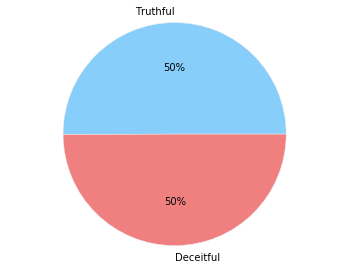

In [33]:
plt.figure()
colors = ['lightskyblue', 'lightcoral']
plt.pie([num_pos_resampled, num_neg_resampled], labels=('Truthful', 'Deceitful'), autopct='%.0f%%', colors=colors)
plt.axis('equal')
plt.show()

In [24]:
X_resampled = X_pos_resampled + X_neg_resampled
# To categorical
y_resampled = np.array([0, 1] * num_pos_resampled +
                       [1, 0] * num_neg_resampled).reshape(-1, 2)
l_resampled = np.array([x.shape[0] for x in X_resampled])

print(len(X_resampled), len(y_resampled), len(l_resampled))

6277 6277 6277


In [25]:
padded = pad_sequences(X_resampled, l_resampled)
X_resampled_padded = np.array(padded, dtype=np.float)

print(X_resampled_padded.shape)

(6277, 1194, 13)


Run the first 25 epochs for inspection

In [17]:
config_2 = Config
config_2.direction = 'uni'
config_2.num_units = 32
config_2.num_layers = 1
config_2.keep_prob = 0.5
config_2.num_epochs = 25

data_2 = train_test_split(X_resampled_padded, y_resampled, l_resampled, test_size=0.1, random_state=13)
records_2 = run_experiment(Polygraph, data_2, config_2, 'log_02')

1/25:
	Batch 10: F/T [68 61], batch_acc 44.2%
	Batch 20: F/T [62 66], batch_acc 46.9%
	Batch 30: F/T [67 61], batch_acc 57.0%
	Batch 40: F/T [75 53], batch_acc 49.2%
Epoch 1/25: train_loss 0.6985, train_acc 49.1%, test_loss 0.6931 test_acc 51.0%, test_auc 52.0%
2/25:
	Batch 10: F/T [67 62], batch_acc 51.9%
	Batch 20: F/T [66 62], batch_acc 50.8%
	Batch 30: F/T [60 68], batch_acc 59.4%
	Batch 40: F/T [55 73], batch_acc 50.8%
Epoch 2/25: train_loss 0.6986, train_acc 51.4%, test_loss 0.6933 test_acc 51.0%, test_auc 51.2%
3/25:
	Batch 10: F/T [66 63], batch_acc 56.6%
	Batch 20: F/T [61 67], batch_acc 57.8%
	Batch 30: F/T [63 65], batch_acc 53.9%
	Batch 40: F/T [74 54], batch_acc 48.4%
Epoch 3/25: train_loss 0.6961, train_acc 52.7%, test_loss 0.6934 test_acc 51.4%, test_auc 50.4%
4/25:
	Batch 10: F/T [65 64], batch_acc 61.2%
	Batch 20: F/T [61 67], batch_acc 57.0%
	Batch 30: F/T [62 66], batch_acc 55.5%
	Batch 40: F/T [69 59], batch_acc 53.1%
Epoch 4/25: train_loss 0.6952, train_acc 52.4%, 

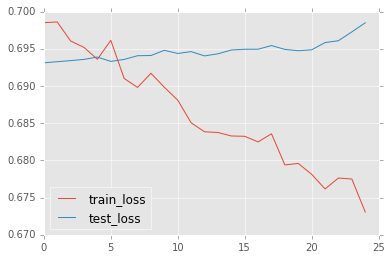

In [27]:
plt.figure()
train_line, = plt.plot(records_2['train_loss'], label='train_loss')
test_line, = plt.plot(records_2['test_loss'], label='test_loss')
plt.legend(handles=[train_line, test_line], loc=3)
plt.show()

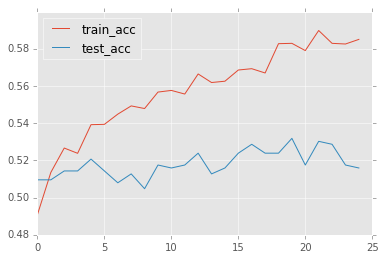

In [31]:
plt.figure()
train_line, = plt.plot(records_2['train_acc'], label='train_acc')
test_line, = plt.plot(records_2['test_acc'], label='test_acc')
plt.legend(handles=[train_line, test_line], loc=2)
plt.show()

### Bidirectional LSTM

In [30]:
config_2 = Config
config_2.rnn_type = 'lstm'
config_2.direction = 'bi'
config_2.num_units = 32
config_2.keep_prob = 0.5
config_2.num_epochs = 25

data_2 = train_test_split(X_resampled_padded, y_resampled, l_resampled, test_size=0.1, random_state=13)
records_2 = run_experiment(Polygraph, data_2, config_2, 'log_02')

1/25:
	Batch 10: F/T [68 61], batch_acc 43.4%
	Batch 20: F/T [58 70], batch_acc 54.7%
	Batch 30: F/T [67 61], batch_acc 44.5%
	Batch 40: F/T [64 64], batch_acc 45.3%
Epoch 1/25: train_loss 0.6989, train_acc 48.9%, test_loss 0.6931 test_acc 50.8%, test_auc 52.2%
2/25:
	Batch 10: F/T [63 66], batch_acc 53.5%
	Batch 20: F/T [61 67], batch_acc 51.6%
	Batch 30: F/T [69 59], batch_acc 54.7%
	Batch 40: F/T [60 68], batch_acc 57.8%
Epoch 2/25: train_loss 0.6971, train_acc 51.1%, test_loss 0.6931 test_acc 52.1%, test_auc 51.7%
3/25:
	Batch 10: F/T [67 62], batch_acc 46.5%
	Batch 20: F/T [60 68], batch_acc 50.0%
	Batch 30: F/T [68 60], batch_acc 53.1%
	Batch 40: F/T [64 64], batch_acc 55.5%
Epoch 3/25: train_loss 0.6969, train_acc 52.0%, test_loss 0.6926 test_acc 52.4%, test_auc 52.8%
4/25:
	Batch 10: F/T [55 74], batch_acc 54.3%
	Batch 20: F/T [73 55], batch_acc 46.1%
	Batch 30: F/T [66 62], batch_acc 52.3%
	Batch 40: F/T [67 61], batch_acc 50.0%
Epoch 4/25: train_loss 0.6970, train_acc 52.1%, 

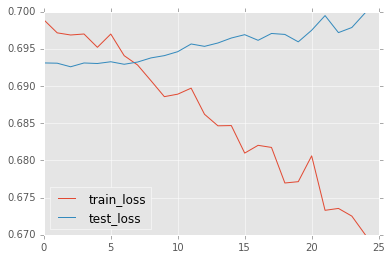

In [31]:
plt.figure()
train_line, = plt.plot(records_2['train_loss'], label='train_loss')
test_line, = plt.plot(records_2['test_loss'], label='test_loss')
plt.legend(handles=[train_line, test_line], loc=3)
plt.show()

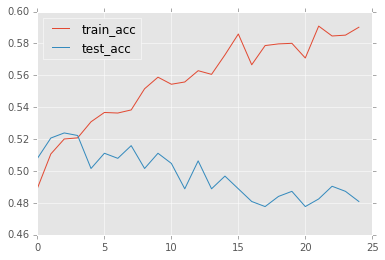

In [32]:
plt.figure()
train_line, = plt.plot(records_2['train_acc'], label='train_acc')
test_line, = plt.plot(records_2['test_acc'], label='test_acc')
plt.legend(handles=[train_line, test_line], loc=2)
plt.show()

The results are not promising, as overfitting becomes more severe.

## Experiement 3: CNN + RNN
Based on the previous observations, it seems to be that raw MFCC features does not provide any useful information for learning, as the test accuracy remains unchanged or flunctuate around the class ratio, indicating the classifier is just randomly guessing the predictions. Overfitting is still very significant.

My hypothesis to what causes this problem is presumably due to the naive resampling in preprocessing. A speech that labeled as "Deceitful" does not suggest the entire speech contains deceptive information. For example, a deceptive speech goes as "My name is Bob. I live on Mars." The first part of the speech is just the speaker stating his name, which should be a "Truth", and the second is marked as "Deceitful". While we slice the data into two pieces marking both as "Deceitful", and this actually generates false information (i.e., noise) to the classifier that ultimately makes the model really vulnerable to noises.

A possible solution is to use the raw input as it is. But since each sequence is way too long for RNN to learn (average around 9000 steps), even LSTM improves gradient vanishing by a great margin, a sequence that long may still degrade the learning process. We want to use input the sequence as long as possible in order to minimize the potential noise generated from resampling.

My proposed solution is to employ CNN + RNN. Instead of directly feeding data into RNN, CNN can be used as feature extractor to pick-up some useful information from the raw MFCC data, meanwhile reducing the sequence length in terms of 2D max pooling. At last we pass the extracted features into RNN as before. The down-side of it is that we will have less samples for training.

In [57]:
class PolygraphCRNN(Polygraph):
    """
    Main model that constructs TF graph and perform training and validation
    
    Args:
        num_units:  Number of hidden units on a RNN layer
        num_layers: Number of RNN layers
        rnn_type:   Type of RNN from 'lstm', 'gru', 'rnn', i.e., LSTM, GRU, regular RNN
        direction:  Choice of unidiretional or bidirection RNN
        lr:         Learning rate
    
    Return:
        Model object
    """
    def __init__(self, num_units, num_layers, rnn_type='lstm', direction='uni', lr=1e-3):
        """Initialization"""
        super(PolygraphCRNN, self).__init__(num_units,
                                            num_layers,
                                            rnn_type=rnn_type,
                                            direction=direction,
                                            lr=lr)

    def _add_prediction_op(self):
        """
        Construct network and predicition op
        This method overwrites the parent class
        """
        # CNN 3 layers of Conv2D + MaxPooling
        max_time = tf.shape(self.inputs)[1]
        
        inputs_cnn = tf.reshape(self.inputs, [-1, max_time, Config.num_feats, 1])
        
        conv_1 = tf.layers.conv2d(inputs=inputs_cnn,
                                  filters=16,
                                  kernel_size=[2, 2],
                                  padding='same',
                                  activation=tf.nn.relu)
        pool_1 = tf.layers.max_pooling2d(inputs=conv_1,
                                         pool_size=[2, 2],
                                         strides=2)

        conv_2 = tf.layers.conv2d(inputs=pool_1,
                                  filters=32,
                                  kernel_size=[2, 2],
                                  padding='same',
                                  activation=tf.nn.relu)
        pool_2 = tf.layers.max_pooling2d(inputs=conv_2,
                                         pool_size=[2, 2],
                                         strides=2)

        conv_3 = tf.layers.conv2d(inputs=pool_2,
                                  filters=64,
                                  kernel_size=[2, 2],
                                  padding='same',
                                  activation=tf.nn.relu)
        pool_3 = tf.layers.max_pooling2d(inputs=conv_3,
                                         pool_size=[2, 2],
                                         strides=2)

        batch_size = tf.shape(pool_3)[0]
        # timesteps has been reduced to 1/8 of original max_time due to 3 levels of pooling
        reduced_steps = tf.shape(pool_3)[1]
        # 'inputs_rnn' is of shape (batch_size, reduced_timesteps, num_filters=64)
        inputs_rnn = tf.reshape(pool_3, [batch_size, reduced_steps, 64])
        # Sequence length reduced to 1/8 as well
        reduced_lens = tf.cast(tf.divide(self.seq_lens, 8), tf.int32)
        
        # RNN cell definition helper
        def rnn_cell(num_units, keep_prob, rnn_type='lstm'):
            if rnn_type == 'lstm':
                cell = tf.nn.rnn_cell.LSTMCell(num_units)
            elif rnn_type == 'gru':
                cell = tf.nn.rnn_cell.GRUCell(num_units)
            elif rnn_type == 'rnn':
                cell = tf.nn.rnn_cell.RNNCell(num_units)
            else:
                raise Exception("Unknown specified rnn_type '{}'".format(rnn_type))
            
            return tf.nn.rnn_cell.DropoutWrapper(cell, output_keep_prob=keep_prob)
        
        # For sequence classification, we need the very last relevant output that supposes to
        # contain the entire information of the sequence from the history 
        last = None
        if self._direction == 'uni':
            # Unidirectional (stacked if layers > 1)
            cell = [rnn_cell(self._num_units, 1., rnn_type=self._rnn_type)
                    for _ in range(self._num_layers)]
            network = tf.nn.rnn_cell.MultiRNNCell(cell)

            # 'outputs' is of shape [batch_size, timesteps, num_units]
            outputs, _ = tf.nn.dynamic_rnn(network,
                                           inputs_rnn,
                                           sequence_length=reduced_lens,
                                           dtype=tf.float32)
            
            # Extract the last relevant output from dynamic run using variable-length sequences
            last = self._extract_relevant(outputs, reduced_lens - 1)
            
        elif self._direction == 'bi':
            # Bidirectional
            cell_fw = rnn_cell(self._num_units, self.keep_prob, rnn_type=self._rnn_type)
            cell_bw = rnn_cell(self._num_units, self.keep_prob, rnn_type=self._rnn_type)
            outputs, _ = tf.nn.bidirectional_dynamic_rnn(cell_fw,
                                                         cell_bw,
                                                         inputs_rnn,
                                                         sequence_length=reduced_lens,
                                                         dtype=tf.float32)
            # Unpack forward/backward outputs
            output_fw, output_bw = outputs
            
            # Not sure why cannot use the staticmethod here!
            # last_fw = self._extract_relevant(output_fw, self.seq_lens - 1) 
            batch_range = tf.range(tf.shape(output_fw)[0])
            indices = tf.stack([batch_range, reduced_lens - 1], axis=1)
            last_fw = tf.gather_nd(output_fw, indices)

            # The last output from the backward layer locates at the first timestep
            last_bw = output_bw[:, 0, :]
            last = tf.concat([last_fw, last_bw], 1)
            
        else:
            raise Exception("Unknown specified direction '{}'".format(self._direction))

        # Apply ReLu
        relu = tf.nn.relu(last, name='relu')
        
        # Apply dropout
        drop = tf.nn.dropout(relu, self.keep_prob)
        
        # For binary classification, we just need one unit from the fully-connected
        # Weights are initialized using truncated normal initializer
        # Biases are initialized with non-zero for layer pre-activation
        self.logits = tf.layers.dense(drop,
                                      units=Config.num_classes,
                                      kernel_initializer=tf.truncated_normal_initializer(stddev=0.01),
                                      bias_initializer=tf.constant_initializer(0.1),
                                      name='dense')
        # self.predictions = tf.cast(tf.greater(self.logits, 0.), tf.float32)
        self.predictions = tf.nn.softmax(self.logits)


In [34]:
X_pos_resampled = resample(X_pos, l_pos, 2000)
X_neg_resampled = resample(X_neg, l_neg, 4800)

num_pos_resampled = len(X_pos_resampled)
num_neg_resampled = len(X_neg_resampled)

In [35]:
print("Pos samples:", num_pos_resampled)
print("Neg samples:", num_neg_resampled)

Pos samples: 361
Neg samples: 360


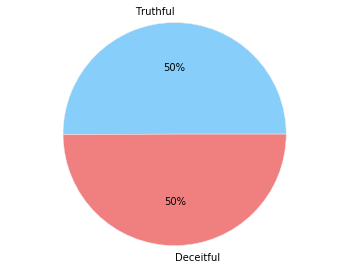

In [36]:
plt.figure()
colors = ['lightskyblue', 'lightcoral']
plt.pie([num_pos_resampled, num_neg_resampled], labels=('Truthful', 'Deceitful'), autopct='%.0f%%', colors=colors)
plt.axis('equal')
plt.show()

In [37]:
X_resampled = X_pos_resampled + X_neg_resampled
# To categorical
y_resampled = np.array([0, 1] * num_pos_resampled +
                       [1, 0] * num_neg_resampled).reshape(-1, 2)
l_resampled = np.array([x.shape[0] for x in X_resampled])

print(len(X_resampled), len(y_resampled), len(l_resampled))

721 721 721


In [38]:
padded = pad_sequences(X_resampled, l_resampled)
X_resampled_padded = np.array(padded, dtype=np.float)

print(X_resampled_padded.shape)

(721, 9398, 13)


In [58]:
config_3 = Config
config_3.rnn_type = 'lstm'
config_3.direction = 'uni'
config_3.num_units = 64
config_3.num_layers = 1
config_3.keep_prob = 0.5
config_3.num_epochs = 25
config_3.batch_size = 18

data_3 = train_test_split(X_resampled_padded, y_resampled, l_resampled, test_size=0.1, random_state=13)
records_3 = run_experiment(PolygraphCRNN, data_3, config_3, 'log_03')

1/25:
	Batch 10: F/T [ 8 10], batch_acc 61.1%
	Batch 20: F/T [10  8], batch_acc 55.6%
	Batch 30: F/T [ 7 11], batch_acc 38.9%
Epoch 1/25: train_loss 0.7294, train_acc 50.5%, test_loss 0.6944 test_acc 49.3%, test_auc 51.6%
2/25:
	Batch 10: F/T [10  8], batch_acc 55.6%
	Batch 20: F/T [ 8 10], batch_acc 44.4%
	Batch 30: F/T [ 8 10], batch_acc 44.4%
Epoch 2/25: train_loss 0.7401, train_acc 50.0%, test_loss 0.6954 test_acc 49.3%, test_auc 51.2%
3/25:
	Batch 10: F/T [11  7], batch_acc 55.6%
	Batch 20: F/T [11  7], batch_acc 61.1%
	Batch 30: F/T [9 9], batch_acc 50.0%
Epoch 3/25: train_loss 0.7380, train_acc 51.2%, test_loss 0.6981 test_acc 49.3%, test_auc 51.1%
4/25:
	Batch 10: F/T [9 9], batch_acc 44.4%
	Batch 20: F/T [ 8 10], batch_acc 50.0%
	Batch 30: F/T [12  6], batch_acc 66.7%
Epoch 4/25: train_loss 0.7229, train_acc 50.9%, test_loss 0.6962 test_acc 49.3%, test_auc 51.7%
5/25:
	Batch 10: F/T [9 9], batch_acc 61.1%
	Batch 20: F/T [11  7], batch_acc 72.2%
	Batch 30: F/T [9 9], batch_acc 

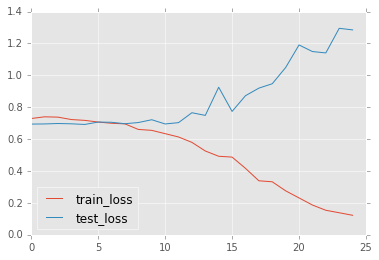

In [59]:
plt.figure()
train_line, = plt.plot(records_3['train_loss'], label='train_loss')
test_line, = plt.plot(records_3['test_loss'], label='test_loss')
plt.legend(handles=[train_line, test_line], loc=3)
plt.show()

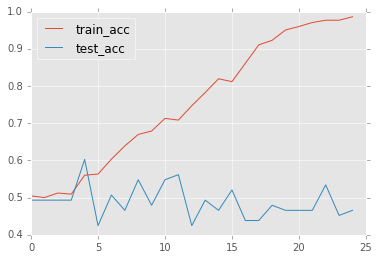

In [60]:
plt.figure()
train_line, = plt.plot(records_3['train_acc'], label='train_acc')
test_line, = plt.plot(records_3['test_acc'], label='test_acc')
plt.legend(handles=[train_line, test_line], loc=2)
plt.show()

## Conclusion
The CNN+RNN setup does not seem to add much value to the model, overfitting remains signficant. As turns out, some previous research conducted has all come to the same conclusions using the CSC Deceptive Speech Corpus. Desai et al. (http://web.stanford.edu/class/cs224s/reports/Shloka_Desai.pdf) have tried several RNN setups, their Audio-only RNN yield 62% accuracy which was their class ratio in the testing set. However, their RNN with lexion inputs seems to produce promising results. Unfortunately in the absense of raw transcripts it is not applicable for me. Similarly, this report also draw the same conclusion applying RNN on this dataset (https://project-archive.inf.ed.ac.uk/ug4/20170931/ug4_proj.pdf). Because lie is very contexutal, there are some underlying challenges presented in the problem, simply audio inputs are not sufficient here.

There are still a few methods worth of tring in the future, such as the attention-based RNN which focus only on part-of the sequence that allows us to pass long sequence. Re-engineering the features will also be helpful, and we can include such as short-term Fourier transform (STFT) spectrogram features. Multimodal inputs as lexicon, emotion would also be beneficial. 